# Final Project PPB - Emotion Detection

Ryan Fernaldy 05111940000152

In [24]:
import numpy as np
import argparse
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import lite
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [2]:
train_dir = 'data/train'
val_dir = 'data/test'

num_train = 28709
num_val = 7178
batch_size = 64
num_epoch = 50

In [3]:
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(48,48),
        batch_size=batch_size,
        color_mode="grayscale",
        class_mode='categorical')

validation_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=(48,48),
        batch_size=batch_size,
        color_mode="grayscale",
        class_mode='categorical')

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


## Buat model

In [4]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48,48,1)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(7, activation='softmax'))

2022-11-25 13:03:12.905636: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-11-25 13:03:12.905661: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ryan): /proc/driver/nvidia/version does not exist
2022-11-25 13:03:12.906116: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
model.compile(loss='categorical_crossentropy',optimizer=Adam(learning_rate=0.0001, decay=1e-6),metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 44, 44, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 22, 22, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 22, 22, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 20, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 10, 128)      0         
 2D)                                                    

In [6]:
history = model.fit(
        train_generator,
        steps_per_epoch=num_train // batch_size,
        epochs=num_epoch,
        validation_data=validation_generator,
        validation_steps=num_val // batch_size)

Epoch 1/50
448/448 [==============================] - 141s 314ms/step - loss: 1.8056 - accuracy: 0.2564 - val_loss: 1.7138 - val_accuracy: 0.3337
Epoch 2/50
448/448 [==============================] - 138s 309ms/step - loss: 1.6263 - accuracy: 0.3635 - val_loss: 1.5425 - val_accuracy: 0.4107
Epoch 3/50
448/448 [==============================] - 162s 361ms/step - loss: 1.5203 - accuracy: 0.4158 - val_loss: 1.4641 - val_accuracy: 0.4438
Epoch 4/50
448/448 [==============================] - 165s 369ms/step - loss: 1.4435 - accuracy: 0.4474 - val_loss: 1.3894 - val_accuracy: 0.4734
Epoch 5/50
448/448 [==============================] - 155s 345ms/step - loss: 1.3772 - accuracy: 0.4759 - val_loss: 1.3255 - val_accuracy: 0.4973
Epoch 6/50
448/448 [==============================] - 158s 353ms/step - loss: 1.3228 - accuracy: 0.5017 - val_loss: 1.2946 - val_accuracy: 0.5074
Epoch 7/50
448/448 [==============================] - 161s 360ms/step - loss: 1.2766 - accuracy: 0.5187 - val_loss: 1.2481 -

In [17]:
def plot_model_history(model_history):
    """
    Plot Accuracy and Loss curves given the model_history
    """
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['accuracy'])+1),model_history.history['accuracy'])
    axs[0].plot(range(1,len(model_history.history['val_accuracy'])+1),model_history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

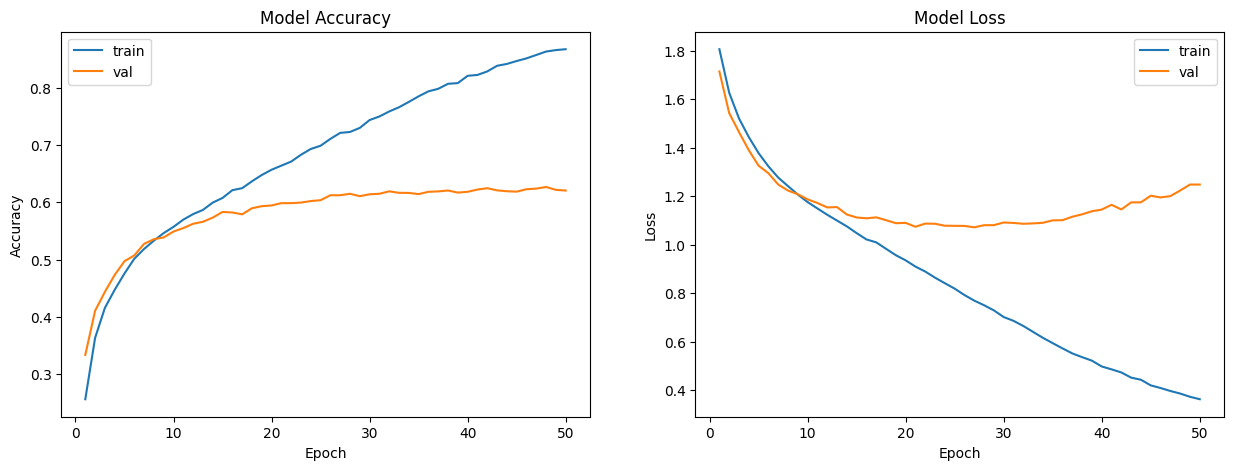

In [18]:
# history.history.keys()
plot_model_history(history)

### Save Weight

In [19]:
model.save_weights('model.h5')

## Predict Emotion

In [101]:
def map_prediction(prediction):
    emotion_dict = {0: "Angry", 1: "Disgusted", 2: "Fearful", 3: "Happy", 4: "Neutral", 5: "Sad", 6: "Surprised"}
    maxindex = int(np.argmax(prediction))

    return emotion_dict[maxindex]

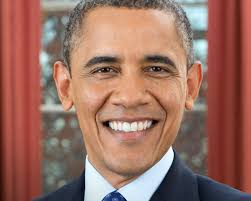

In [102]:
from IPython.display import Image, display

display(Image(filename="tes.jpeg"))

In [103]:
from PIL import Image, ImageOps, ImageDraw
img = Image.open("tes.jpeg").convert('L').resize((48, 48), Image.ANTIALIAS)
gray = ImageOps.grayscale(img) #convert to grayscale
gray = np.array(gray)
prediction = model.predict(gray[None,:,:])

1/1 [==============================] - 0s 18ms/step


In [104]:
print(map_prediction(prediction))

Angry


Hasil prediksi tidak sesuai harapan karena gambar input belum di preprocess

## Face Detection From Input

In [105]:
gray = ImageOps.grayscale(Image.open("tes.jpeg"))
gray = np.array(gray)

In [106]:
from PIL import Image
facecasc = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
faces = facecasc.detectMultiScale(gray,scaleFactor=1.3, minNeighbors=5)
img = Image.open("tes.jpeg")

shapes = []
for (x, y, w, h) in faces:
    shape = ((x,y), (x+w,y+h))
    shapes.append(shape)
    img1 = ImageDraw.Draw(img)  
    img1.rectangle(shape, outline ="red")
    
img.save('tes-face-detection.jpeg')

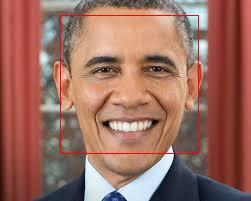

In [107]:
from IPython.display import Image, display

display(Image(filename="tes-face-detection.jpeg"))

In [108]:
# crop image
# print(shape)
images = []
for shape in shapes:
    ((x1, y1), (x2, y2)) = shape
    cropped = img.crop((x1,y1,x2,y2))
    images.append(cropped)

In [109]:
ctr = 0
for image in images:
    image.save(f"{ctr}.jpeg")
    ctr = ctr+1

## Predict cropped image

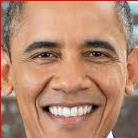

In [110]:
from IPython.display import Image, display

display(Image(filename="0.jpeg"))

In [112]:
from PIL import Image
img = Image.open("0.jpeg").convert('L').resize((48, 48))
gray = ImageOps.grayscale(img)
img = np.array(gray)
prediction2 = model.predict(img[None,:,:])

1/1 [==============================] - 0s 18ms/step


In [113]:
print(map_prediction(prediction2))

Happy


## Load Saved Model

In [20]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48,48,1)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(7, activation='softmax'))

In [22]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 46, 46, 32)        320       
                                                                 
 conv2d_5 (Conv2D)           (None, 44, 44, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 22, 22, 64)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 22, 22, 64)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 20, 20, 128)       73856     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 10, 10, 128)      0         
 2D)                                                  

In [21]:
model.load_weights('model.h5')

## Convert ke TFLite

In [25]:
converter = lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open("model.tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpja4mx0lw/assets


INFO:tensorflow:Assets written to: /tmp/tmpja4mx0lw/assets
2022-11-25 15:13:11.598989: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-25 15:13:11.599021: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-25 15:13:11.599649: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpja4mx0lw
2022-11-25 15:13:11.601691: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-25 15:13:11.601718: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpja4mx0lw
2022-11-25 15:13:11.609243: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled
2022-11-25 15:13:11.610936: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-25 15:13:11.646656: I tensorflow/cc/saved_model/loader.cc:213] Running initializatio

9387136